In [2]:
#imports

import h5py
import numpy as np
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [43]:
# Set Recording Session
year = '2024'
month = '12'
day = '06'

# Hyperparameters
model_type = 'model'
layer = 'conv402'
sh_limit = .3
monkey = 'Bourgeois'
image_set = 'HvM'
category = None
min_repeat = 2

notes = 'New pipeline '

#set model_title

if model_type == 'model':
    model_title = f'Trained ResNet50 ({layer})'
elif model_type == 'rand':
    model_title = f'Untrained ResNet50 ({layer})'
elif model_type == 'barlow':
    model_title = f'Trained Barlow Model ({layer})'
elif model_type == 'model34':
    model_title = f'Trained ResNet34 ({layer})'
elif model_type == 'model18':
    model_title = f'Trained ResNet18 ({layer})'

hyperparameters = f'{notes}{model_title}, {image_set}, {min_repeat} reps, {year}{month}{day}'
folder = f'{monkey} {image_set} Figures'

trials_included = 10000

In [4]:
# Load data

marm_avg_spikes_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_{year}{month}{day}.npy')
marm_avg_spikes = zscore(np.transpose(marm_avg_spikes_t.astype('float32')), axis=1)[:trials_included]

marm_model_outputs_bad = np.load(f'./{year}_{month}_{day}/marm_{model_type}_{layer}outputs_{year}{month}{day}.npy')[:trials_included]
marm_model_outputs = zscore(marm_model_outputs_bad, axis=1)

print(marm_avg_spikes.shape)
print(marm_model_outputs.shape)

(8971, 384)
(8971, 25088)


In [5]:
# load and test neural

neural_tot = marm_avg_spikes
neural_dim = marm_avg_spikes.shape[1]

print("neural min:", neural_tot.min())
print("neural max:", neural_tot.max())
print("neural mean:", neural_tot.mean())
print("neural std:", neural_tot.std())

neural_tot.shape

neural min: -0.9290847
neural max: 10.997089
neural mean: -4.6088235e-09
neural std: 0.9999999


(8971, 384)

In [6]:
# load and test model outputs

model_tot = marm_model_outputs

print("outputs min:", model_tot.min())
print("outputs max:", model_tot.max())
print("outputs mean:", model_tot.mean())
print("outputs std:", model_tot.std())

model_tot.shape

outputs min: -11.9030357255766
outputs max: 10.063609101751927
outputs mean: -9.071821735286453e-19
outputs std: 0.9999999999999987


(8971, 25088)

In [7]:
# Subset of model outputs

model_outputs_dim = 300

rand_idx = np.arange(model_tot.shape[1])
np.random.shuffle(rand_idx)
subset_idx = rand_idx[:model_outputs_dim]

subset_outputs = model_tot[:, subset_idx]

subset_outputs.shape

(8971, 300)

In [8]:
# make new indices for SHR
ch_tot = marm_avg_spikes.shape[1]
stim_tot = marm_avg_spikes.shape[0]
indices = np.arange(stim_tot)

In [9]:
# load natimg_path_list

with open(f'./{year}_{month}_{day}/natimg_path_list_{year}{month}{day}', 'rb') as fp:   # Unpickling
    natimg_path_list = pickle.load(fp)

natimg_path_list = natimg_path_list[:trials_included]
len(natimg_path_list)

8971

In [10]:
# get max_reps

trial_counts = []

for path in set(natimg_path_list):
    trial_counts.append(natimg_path_list.count(path))

max_reps = max(trial_counts)

print(max_reps)

25


In [11]:
# Check when choosing min reps

for reps in range(0, max_reps+1, 2):
    print(f'Min Reps: {reps}, Images: {len([x for x in trial_counts if x>=reps])}')

Min Reps: 0, Images: 450
Min Reps: 2, Images: 450
Min Reps: 4, Images: 450
Min Reps: 6, Images: 450
Min Reps: 8, Images: 450
Min Reps: 10, Images: 450
Min Reps: 12, Images: 450
Min Reps: 14, Images: 450
Min Reps: 16, Images: 445
Min Reps: 18, Images: 398
Min Reps: 20, Images: 266
Min Reps: 22, Images: 95
Min Reps: 24, Images: 15


In [12]:
# HVM: Get demon matrix for each neuron

many_path_list = [path for path in natimg_path_list 
                      if natimg_path_list.count(path) >= min_repeat]
img_count = len(set(many_path_list))
sh_data = np.zeros(ch_tot)
img_spikes_tot = np.zeros((ch_tot, max_reps, img_count))

for ch in range(ch_tot):
    neuron = marm_avg_spikes[:, ch]
    count_arr = np.zeros((max_reps, img_count))
    count_arr[:] = np.nan
    for i, path in enumerate(set(many_path_list)):
        idx_list = [i for i, j in enumerate(natimg_path_list) if j == path]
        # note: original mistake, ^ should take natimg_path_list as arg
        for rep, idx in enumerate(idx_list):
            count_arr[rep, i] = neuron[idx]
    img_spikes_tot[ch] = count_arr
    neuron_1, neuron_2 = count_arr[::2], count_arr[1::2]
    neuron_1_avg = np.nanmean(neuron_1, axis=0)
    neuron_2_avg = np.nanmean(neuron_2, axis=0)
    sh, _ = stats.pearsonr(neuron_1_avg, neuron_2_avg)
    sh_data[ch] = sh

In [13]:
# Get good idx
good_idx = np.where(sh_data >= sh_limit)[0]

# get good sh, exp
good_sh = sh_data[good_idx]

good_ch_tot = good_idx.shape[0]

print(f'Number of good neurons: {good_ch_tot}')

Number of good neurons: 203


In [ ]:
#pseudo code

'''
for each fold
    if only 1 of the image
        add that index to "insufficient_repeat_indices"
    else
        for each image, train_test_split the indices
        put train indices in train
        put test indices in test
'''

'''
Making dict

for each image
    get list of indices of that image
    {image: list}
'''

In [19]:
# Create indices
folds = 3
indices = np.arange(stim_tot)

indices_list = []

insufficient_img_idxs = []

for i in range(folds):
    train_indices = []
    test_indices = []
    for image_name in set(natimg_path_list):

        # Get image indices
        image_idxs = [i for i, x in enumerate(natimg_path_list) if x==image_name] 
        
        # Check if image is sufficiently repeated
        if len(image_idxs) < min_repeat:
            insufficient_img_idxs.append(image_idxs[0])
        
        # split indices
        else:
            img_train_indices, img_test_indices = train_test_split(
                image_idxs, test_size = .5)
             
            # add to train_indices, test_indices
            train_indices.extend(img_train_indices)
            test_indices.extend(img_test_indices)

    #Convert to np + sort train/test indices
    train_indices = np.sort(np.array(train_indices))
    test_indices = np.sort(np.array(test_indices))
    
    # Get indices_set for fold, add to indices_list
    indices_set = [train_indices, test_indices]
    indices_list.append(indices_set)

print(f'Final fold train indices: {len(train_indices)} \nFinal fold test indices: {len(test_indices)}')
'''NOTE: train test split gives more to test on odd distributions'''

Final fold train indices: 4369 
Final fold test indices: 4602


'NOTE: train test split gives more to test on odd distributions'

In [20]:
# prepare for loop cv

scores_tot = np.zeros((folds, good_ch_tot))
alphas_tot = np.zeros((folds, good_ch_tot))
exp_data_tot = np.zeros((folds, good_ch_tot))
corr_data_tot = np.zeros((folds, good_ch_tot))
lr_outputs_np_tot = np.zeros((folds, indices_list[0][1].shape[0], good_ch_tot))
print(lr_outputs_np_tot.shape)

(3, 4602, 203)


In [26]:
# Check for number of components
max_components = min(model_tot.shape[1]//2, model_tot.shape[0])

for i in range(50, max_components, 50):
    pca = PCA(n_components = i)
    pca.fit(model_tot)
    print(f'{i} : {pca.explained_variance_ratio_.sum() * 100:.4f}')
    if pca.explained_variance_ratio_.sum() >= 1:
        break

50 : 89.4537
100 : 95.1020
150 : 97.3845
200 : 98.5437
250 : 99.1981
300 : 99.5849
350 : 99.8129
400 : 99.9446
450 : 100.0027


In [21]:
# Set components
num_comps = 450

pca = PCA(n_components = num_comps)
pca_outputs = pca.fit_transform(model_tot)
pca.explained_variance_ratio_.sum()

0.9999999999999987

In [22]:
# for loop regression
'''
alphas_list = [.01, .02, .05, .1, .5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000,
               10000, 25000, 50000, 100000, 500000]
'''
alphas_list = [.01, .02, .05, .1, .5, 1, 5, 10]


for fold, tt_idx in enumerate(indices_list):
    train_indices, test_indices = tt_idx[0], tt_idx[1]
    
    predictions = np.zeros((test_indices.shape[0], good_ch_tot))
    scores = np.zeros(good_ch_tot)
    alphas = np.zeros(good_ch_tot)
    
    for i in range(good_ch_tot):
        neuron = marm_avg_spikes[:, good_idx[i]]
        model = RidgeCV(alphas=alphas_list).fit(pca_outputs[train_indices], neuron[train_indices])
        synth_neuron = model.predict(pca_outputs[test_indices])
        predictions[:, i] = synth_neuron
        scores[i] = model.score(pca_outputs[train_indices], neuron[train_indices])
        alphas[i] = model.alpha_

    lr_outputs_np_tot[fold] = predictions

    # Check scores
    scores_tot[fold] = scores

    # Check alphas
    alphas_tot[fold] = alphas
    
    for i in range(good_ch_tot):
        neuron = marm_avg_spikes[:, good_idx[i]]
        y = r2_score(neuron[test_indices], predictions[:, i])
        z, _ = stats.pearsonr(neuron[test_indices], predictions[:, i])
        exp_data_tot[fold, i] = y
        corr_data_tot[fold, i] = z
    
    # Individual Explained Variance
    exp_var = r2_score(marm_avg_spikes[test_indices, :][:, good_idx], predictions)
    print(f"Explained Variance of the model: {100*exp_var:.2f}%")

Explained Variance of the model: 7.39%
Explained Variance of the model: 7.47%
Explained Variance of the model: 7.36%


In [28]:
# Check alphas

for i in alphas_list:
    print(f'{i} : {np.where(alphas_tot == i)[0].shape[0]}')

0.01 : 0
0.02 : 0
0.05 : 0
0.1 : 0
0.5 : 0
1 : 0
5 : 0
10 : 609


In [29]:
# Get good_exp, good_corr

good_exp = exp_data_tot.mean(axis = 0)
good_corr = corr_data_tot.mean(axis = 0)
good_corr.shape

(203,)

In [52]:
# Set metric, model_title

eval = 'r'

if eval == 'r':
    metric = good_corr
    y_label = 'Correlation of model output, neuron'
    title = 'Correlation vs SHR'
    eval_scores = np.sqrt(scores_tot)
elif eval == 'R^2':
    metric = good_exp
    y_label = 'Explained Variance by model'
    title = 'ExpVar vs SHR'
    eval_scores = scores_tot

print(eval)

r


In [1]:
# Create histogram for SHR
set_bins = np.arange(21)*.05
plt.hist(good_sh, bins = set_bins, edgecolor = 'black', alpha = .8)
plt.hist(good_corr, bins = set_bins, edgecolor = 'red', alpha = .5)
plt.title(f'{title} ({model_title})')
plt.xlabel(f'SHR (blue) and {eval}(model, neuron) (orange)')
plt.show()

NameError: name 'np' is not defined

In [54]:
# Placeholder ch_depth
ch_depth = np.load(f'./2024_04_03/ch_depth_20240403.npy')

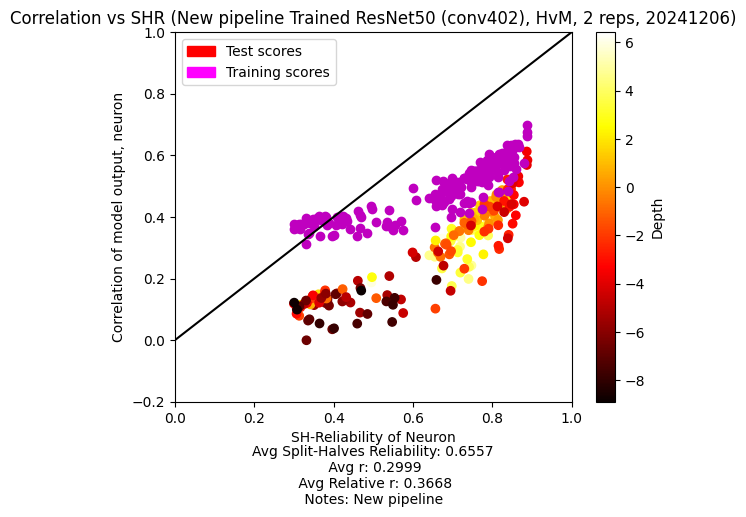

In [55]:
# Create plot

# Colors
#ch_depth = np.load(f'./{year}_{month}_{day}/ch_depth_{year}{month}{day}.npy')

# Plot
scatter = plt.scatter(
    good_sh, metric, c = ch_depth[good_idx], cmap = 'hot')
plt.title(f'{title} ({hyperparameters})')
plt.ylabel(y_label)
plt.xlabel('SH-Reliability of Neuron')

#colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Depth')

# Additional
plt.axline((0, 0), slope=1, c='k')
scatter = plt.scatter(
    good_sh, eval_scores.mean(axis=0), c = 'm')
r_patch = mpatches.Patch(color='red', label = 'Test scores')
m_patch = mpatches.Patch(color='magenta', label = 'Training scores')
plt.legend(handles = [r_patch, m_patch], loc = "upper left")

# Set X-axis
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([-.2, 1])

# Add caption
r, p = stats.pearsonr(good_sh, metric)
relative_exp = metric / (2 * good_sh / (1 + good_sh))

plt.text(0.5, -0.2, f'Avg Split-Halves Reliability: {good_sh.mean():.4f}'
         f'\n Avg {eval}: {metric.mean():.4f}'
         f'\n Avg Relative {eval}: {relative_exp.mean():.4f}'
         f'\n Notes: {notes}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

# Show the plot
plt.show()

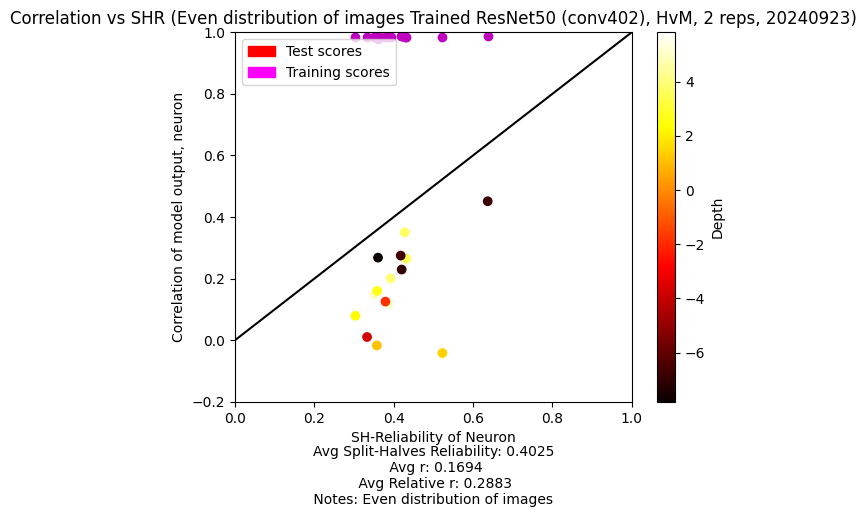

In [36]:
# Save it

# Create plot

# Colors
ch_depth = np.load(f'./{year}_{month}_{day}/ch_depth_{year}{month}{day}.npy')

# Plot
scatter = plt.scatter(
    good_sh, metric, c = ch_depth[good_idx], cmap = 'hot')
plt.title(f'{title} ({hyperparameters})')
plt.ylabel(y_label)
plt.xlabel('SH-Reliability of Neuron')

#colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Depth')

# Additional
plt.axline((0, 0), slope=1, c='k')
scatter = plt.scatter(
    good_sh, eval_scores.mean(axis=0), c = 'm')
r_patch = mpatches.Patch(color='red', label = 'Test scores')
m_patch = mpatches.Patch(color='magenta', label = 'Training scores')
plt.legend(handles = [r_patch, m_patch], loc = "upper left")

# Set X-axis
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([-0.2, 1])

# Add caption
r, p = stats.pearsonr(good_sh, metric)
relative_exp = metric / (2 * good_sh / (1 + good_sh))

plt.text(0.5, -0.2, f'Avg Split-Halves Reliability: {good_sh.mean():.4f}'
         f'\n Avg {eval}: {metric.mean():.4f}'
         f'\n Avg Relative {eval}: {relative_exp.mean():.4f}'
         f'\n Notes: {notes}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

# Save plot
plt.savefig(f'/Users/parsatalaie/Desktop/{folder}/{hyperparameters}', bbox_inches='tight')

In [36]:
# Aggregate all responses, linreg into one dict
resp_dict = {'IT Data': neural_tot[:, good_idx][indices_list[0][1]], 
             'Model Output': pca_outputs[indices_list[0][1]]}

print(resp_dict['IT Data'].shape)
print(resp_dict['Model Output'].shape)

(4602, 203)
(4602, 450)


In [47]:
# Plotting Functions

def show_stimulus(img, ax=None, show=False):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if show:
    plt.show()


def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()


def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(resp_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)

def plot_rdm_rdm_correlations(rdm_sim):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith IT Data')
  plt.show()


def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(rdm_oris, rdm[iori, :], label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))
  plt.tight_layout()
  plt.show()

In [38]:
# Define correlate_rdms
def correlate_rdms(rdm1, rdm2):
    """Correlate off-diagonal elements of two RDM's
  
    Args:
      rdm1 (np.ndarray): S x S representational dissimilarity matrix
      rdm2 (np.ndarray): S x S representational dissimilarity matrix to
        correlate with rdm1
  
    Returns:
      float: correlation coefficient between the off-diagonal elements
        of rdm1 and rdm2
  
    """
  
    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]
  
    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  
    return corr_coef

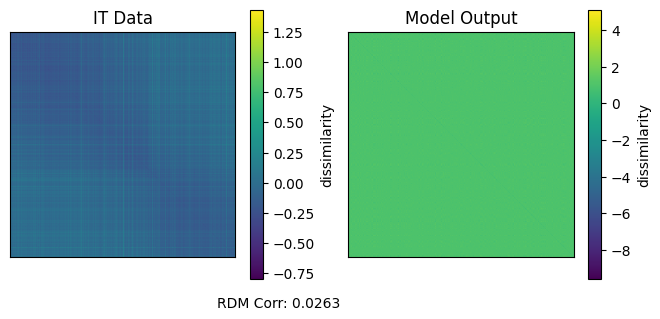

In [48]:
# RDM def and plot

def RDM(resp):
    """Compute the representational dissimilarity matrix (RDM)
  
    Args:
      resp (ndarray): S x N matrix with population responses to
        each stimulus in each row
  
    Returns:
      ndarray: S x S representational dissimilarity matrix
    """
  
    # z-score responses to each stimulus
    zresp = resp #zscore(resp, axis=1)
  
    # Compute RDM
    RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]
    return RDM


# Compute RDMs for each layer
rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}

# Plot RDMs
plot_multiple_rdm(rdm_dict)

# Correlate RDMs

# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_IT = rdm_model.pop('IT Data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_IT, rdm) for label, rdm in rdm_model.items()}

plt.text(0.5, -0.1, f'RDM Corr: {rdm_sim['Model Output']:.4f}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

plt.show()

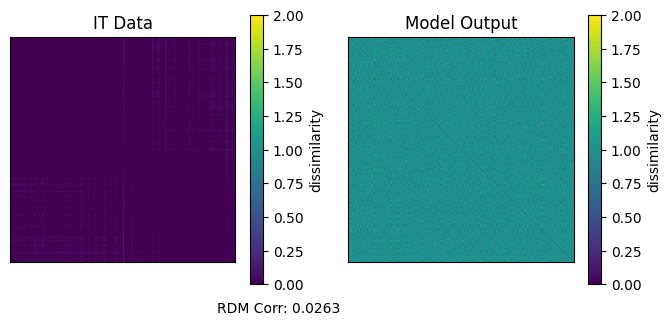

In [40]:
# Save RDM

def RDM(resp):
    """Compute the representational dissimilarity matrix (RDM)
  
    Args:
      resp (ndarray): S x N matrix with population responses to
        each stimulus in each row
  
    Returns:
      ndarray: S x S representational dissimilarity matrix
    """
  
    # z-score responses to each stimulus
    zresp = resp #zscore(resp, axis=1)
  
    # Compute RDM
    RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]
    return RDM


# Compute RDMs for each layer
rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}

# Plot RDMs
plot_multiple_rdm(rdm_dict)

# Correlate RDMs

# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_IT = rdm_model.pop('IT Data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_IT, rdm) for label, rdm in rdm_model.items()}

plt.text(0.5, -0.1, f'RDM Corr: {rdm_sim['Model Output']:.4f}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

plt.savefig(f'/Users/parsatalaie/Desktop/{folder}/{hyperparameters} RDM', bbox_inches='tight')